In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import polyphase
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.cm import ScalarMappable
from matplotlib import colors

In [3]:
M = [1,1,1,1] 
chi = 3.10*np.ones(int(0.5*4*(4-1)))
# M = [5,5,1,1] 
# chi = [1,0.5,0.5,0.5,0.5,1]

f = lambda x : polyphase.flory_huggins(x, M, chi)
engine = polyphase.PHASE(f,100,4)
engine.compute()

Computation took 132.87s


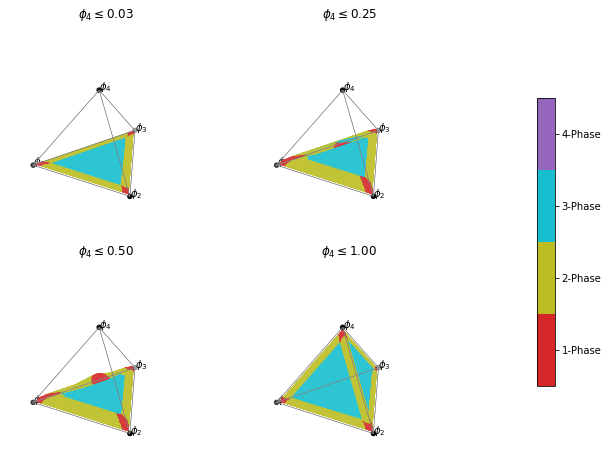

In [4]:
qtplot = polyphase.QuaternaryPlot(engine)
[fig, axs, cbar] = qtplot.show()
plt.show()

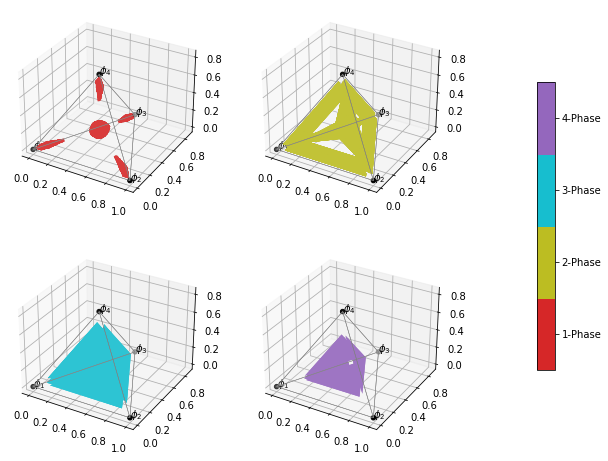

In [5]:
qtplot.plot_simplices()
plt.show()

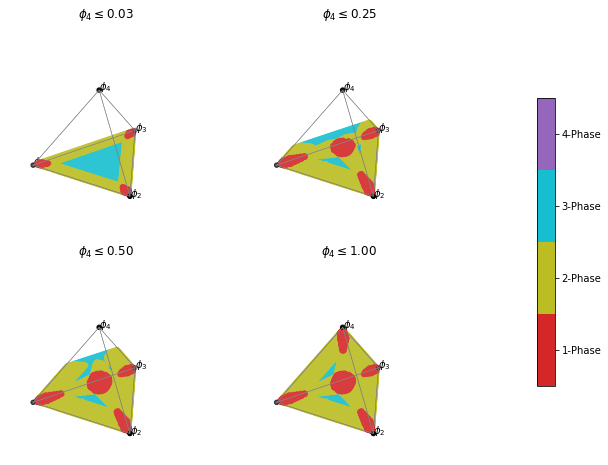

In [6]:
qtplot.show(mode='points')
plt.show()

In [19]:
from pathlib import Path
import shutil, os
import imageio

def togif(engine,num=10):
    dirpath = '../figures/togif/'
    if os.path.exists(dirpath):
        shutil.rmtree(dirpath)
        
    os.mkdir(dirpath)
    
    def add_tetrahedron_slice(PHI4,ax):
        phase_colors =['tab:red','tab:olive','tab:cyan','tab:purple']
        cmap = colors.ListedColormap(phase_colors)
        slice_ids = engine.grid[3,:]<=PHI4
        for i in [1,2,3,4]:
            phase_ids = engine.df.T['label']==i
            ids = np.logical_and(slice_ids, phase_ids)
            ax.scatter(qtplot.threed_coords[ids,0],
                       qtplot.threed_coords[ids,1],
                       qtplot.threed_coords[ids,2],
                       c = phase_colors[int(i-1)], s=1)
            
    PHI4s = np.linspace(0.03,0.99,num=num)
    qtplot = polyphase.QuaternaryPlot(engine)
    filenames = []
    for ind,val in enumerate(PHI4s):
        fig, ax = plt.subplots(subplot_kw={'projection':'3d'})
        qtplot.add_outline(ax)
        ax._axis3don = False
        add_tetrahedron_slice(val,ax)
        fname = dirpath+'{}.png'.format(ind)
        plt.savefig(fname, dpi=400, bbox_inches='tight')
        plt.close()
        filenames.append(fname)
        
    gname = '../figures/notebooks/1.gif'
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
        os.remove(filename)
    imageio.mimsave(gname, images, fps=1)
    print('View the GIF at {}'.format(gname))
    
togif(engine,num=20)

View the GIF at ../figures/notebooks/1.gif


Total of 9604 many points
Total of 5776 many points
Total of 2601 many points
Total of 676 many points


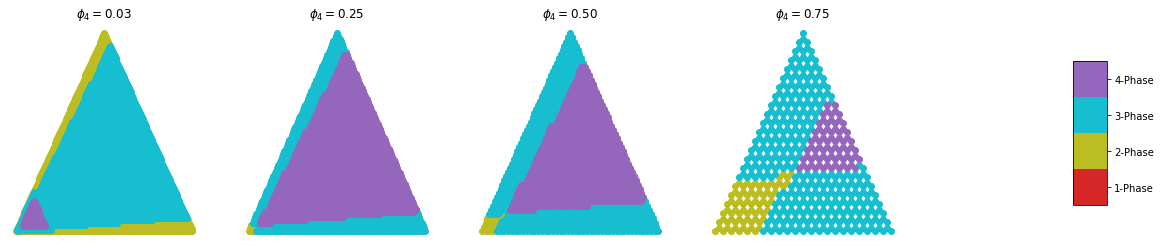

In [29]:
# compare slice from the 4-component system to its equivalent ternary phase diagram
from matplotlib import colors

def project_fourd_slice(engine,PHI4, ax):
    phase_colors =['tab:red','tab:olive','tab:cyan','tab:purple']
    cmap = colors.ListedColormap(phase_colors)
    slice_ids = np.isclose(engine.grid[3,:],PHI4, atol=0.01)
    print('Total of {} many points'.format(np.sum(slice_ids)))
    for i in [1,2,3,4]:
        phase_ids = engine.df.T['label']==i
        ids = np.logical_and(slice_ids, phase_ids)
        ax.scatter(qtplot.threed_coords[ids,0],qtplot.threed_coords[ids,1],
                   c = phase_colors[int(i-1)])
    ax.axis('off')
    
def show_slices(engine):
    fig, axs = plt.subplots(1,4,figsize=(4*4,4))
    qtplot = polyphase.QuaternaryPlot(engine)
    PHI4s = [0.025,0.25,0.5,0.75]
    for i in range(4):
        project_fourd_slice(engine,PHI4s[i],axs[i])
        axs[i].set_title(r'$\phi_{4}=$'+'{:.2f}'.format(PHI4s[i]))
    qtplot.add_colorbar(fig)
    plt.show()
    
show_slices(engine)

## From solvent solubulities

In [16]:
import pandas as pd

solvents = pd.read_pickle('../data/solvents.pkl')
polymers = pd.read_pickle('../data/polymers.pkl')
SMs = pd.read_pickle('../data/SM.pkl')

In [19]:
polymer = polymers[polymers['name']=='PM6']
sm = SMs[SMs['name']=='Y6']
sol1 = solvents[solvents['Solvents']=='Butyl Benzoate']
sol2 = solvents[solvents['Solvents']=='Acetone']

In [31]:
def get_system(polymer, sm, sol1, sol2):
    delta_sol1 = sol1[['dD','dP','dH']].values[0]
    M_ref = sol2['MVol'].values[0]

    M_sol1 = sol1['MVol'].values[0]/M_ref
    
    delta_sol2 = sol2[['dD','dP','dH']].values[0]
    M_sol2 = sol2['MVol'].values[0]/M_ref
    
    delta_sm = sm[['dD','dP','dH']].values[0]
    M_sm = (sm['MW'].values[0]/sm['rho'].values[0])*(1/M_ref)
    
    delta_polymer = polymer[['dD','dP','dH']].values[0]
    M_polymer = (polymer['MW'].values[0]/polymer['rho'].values[0])*(1/M_ref)
    
    M = [M_polymer, M_sm, M_sol1, M_sol2]
    chi,inds = polyphase.get_chi_vector([delta_polymer,delta_sm,delta_sol1, delta_sol2], M_ref, approach=2)
    
    return M, chi, inds

M, chi, inds = get_system(polymer, sm, sol1, sol2)

Computation took 24.18s


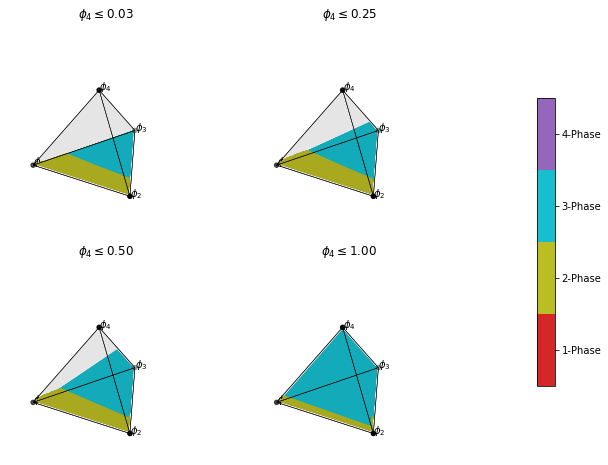

In [24]:
f = lambda x : polyphase.flory_huggins(x, M, chi)
engine = polyphase.PHASE(f,100,4)
engine.compute()
engine.plot()

Total of 9604 many points
Total of 5776 many points
Total of 2601 many points
Total of 676 many points


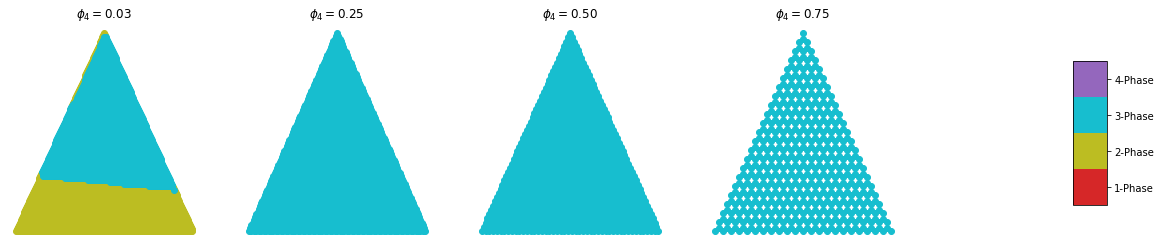

In [25]:
show_slices(engine)

Computation took 5.76s
(0, 1, 2) [1120.632256490311, 14.404273188350158, 2.413279132791328] [0.37977084451424736, 0.4364121960527647, 0.583808709370037]
Computation took 5.62s
(0, 1, 3) [1120.632256490311, 14.404273188350158, 1.0] [0.37977084451424736, 1.8967081355299202, 2.3935271110650627]
Computation took 8.87s
(0, 2, 3) [1120.632256490311, 2.413279132791328, 1.0] [0.4364121960527647, 1.8967081355299202, 1.3202172881691825]
Computation took 7.16s
(1, 2, 3) [14.404273188350158, 2.413279132791328, 1.0] [0.583808709370037, 2.3935271110650627, 1.3202172881691825]


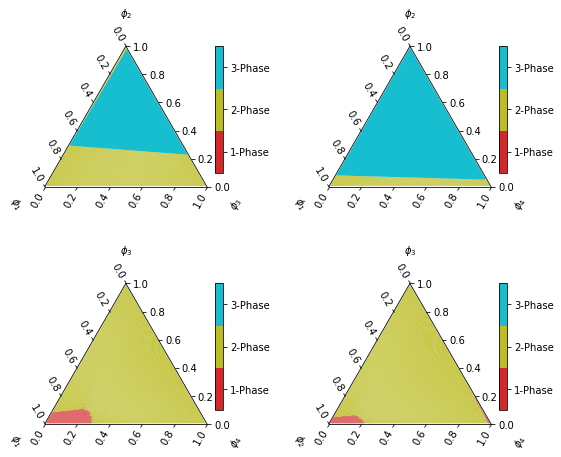

In [22]:
from itertools import combinations
M_inds = list(combinations([0,1,2,3],3))
CHI = polyphase._utri2mat(chi,4)

fig, axs = plt.subplots(2,2,figsize=(8,8),subplot_kw={'projection':'ternary'})
axs = axs.flatten()
fig.subplots_adjust(wspace=0.75,hspace=0.2)
for ax,M_ind in zip(axs,M_inds):
    chi_inds = list(combinations(M_ind,2))
    chi_proj = [CHI[i] for i in chi_inds]
    M_proj = [M[i] for i in M_ind]

    f = lambda x : polyphase.flory_huggins(x, M_proj, chi_proj)
    engine = polyphase.PHASE(f,200,len(M_proj))
    engine.compute()
    
    ternplot = polyphase.TernaryPlot(engine)
    ternplot.plot_simplices(ax=ax, label=False)
    
    ax.set_tlabel(r'$\phi_{}$'.format(M_ind[1]+1))
    ax.set_llabel(r'$\phi_{}$'.format(M_ind[0]+1))
    ax.set_rlabel(r'$\phi_{}$'.format(M_ind[2]+1))

    print(M_ind, M_proj, chi_proj)
    
plt.show()